In [1]:
from __future__ import print_function

import sys

sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm

from datetime import datetime
from pytz import timezone
import copy

import numpy as np
import torch

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from in_out.detector.detector_dataset import RegionDetectorDataSet
from config.config import config
from common.detector.config import config_detector
from plotting.color_maps import transparent_cmap
from utils.exper_hdl_ensemble import ExperHandlerEnsemble
from common.dslices.config import config
from common.detector.box_utils import find_bbox_object, BoundingBox
from utils.detector.batch_handler import BatchHandler
from utils.detector.experiment import Experiment
from utils.detector.exper_handler import ExperimentHandler

mycmap = transparent_cmap(plt.get_cmap('jet'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"

# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Load our baseline 
seg_exper_ensemble = ExperHandlerEnsemble(config.exper_dict_brier)

Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['0'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['1'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['2'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['3'] loss=brier


In [3]:
from in_out.detector.detector_dataset import create_dataset

dataset = create_dataset(seg_exper_ensemble, train_fold_id=0, quick_run=False, num_of_input_chnls=3,
                         model_name="rd3")

INFO - Preparing experimental handlers. This may take a while. Be patient...
INFO - Ready. Loop through patient ids.


100%|██████████| 100/100 [00:26<00:00,  3.73it/s]


In [6]:
roi_stats = dataset.roi_stats["train"]
print(roi_stats)
print("Perc of positives {:.5f}".format(float(roi_stats[1])/roi_stats[0]))

[1359330    1130     409     721]
Perc of positives 0.00083


In [87]:
batch_size = 8
new_batch = BatchHandler(dataset, is_train=False, cuda=True, keep_bounding_boxes=False, verbose=False)


In [89]:
for batch_imgs, target_labels_per_roi in new_batch(batch_size=8, keep_batch=True):
    print(new_batch.current_slice_ids)


[8]
[8, 9]
[8, 9, 10]
[8, 9, 10, 11]
[8, 9, 10, 11, 12]
[8, 9, 10, 11, 12, 13]
[8, 9, 10, 11, 12, 13, 14]
[8, 9, 10, 11, 12, 13, 14, 15]


In [ ]:
idx = None
for s in np.arange(len(dataset.test_labels)):
    img = dataset.test_labels[s]
    if 0 != np.count_nonzero(img):
        idx = s
    
        if idx > 25:
            break
    
idx = 133
test_img = dataset.test_images[idx]
test_lbl = dataset.test_labels[idx]
test_pred_roi = dataset.test_pred_lbl_rois[idx]
print(test_img.shape, test_lbl.shape)
print(test_pred_roi)

fig = plt.figure(figsize=(56, 50))
ax1 = plt.subplot2grid((2, 4), (0, 0), rowspan=2, colspan=2)
ax1.imshow(test_img[0], cmap=cm.gray)
ax1.imshow(test_img[2], cmap=mycmap)
# ax1.imshow(test_lbl, cmap=mycmap)
# ax1.imshow(test_img[1], cmap=mycmap)
roi_box = BoundingBox.create(test_pred_roi, padding=0)
print(roi_box.width, roi_box.height)
ax1.add_patch(roi_box.get_matplotlib_patch(color='b'))

plt.axis("off")
plt.show()
# ax2 = plt.subplot2grid((2, 4), (0, 2), rowspan=2, colspan=2)
# ax2.imshow(test_lbl, cmap=cm.gray)
# plt.axis("off")

[ 150.   74.  222.  146.]


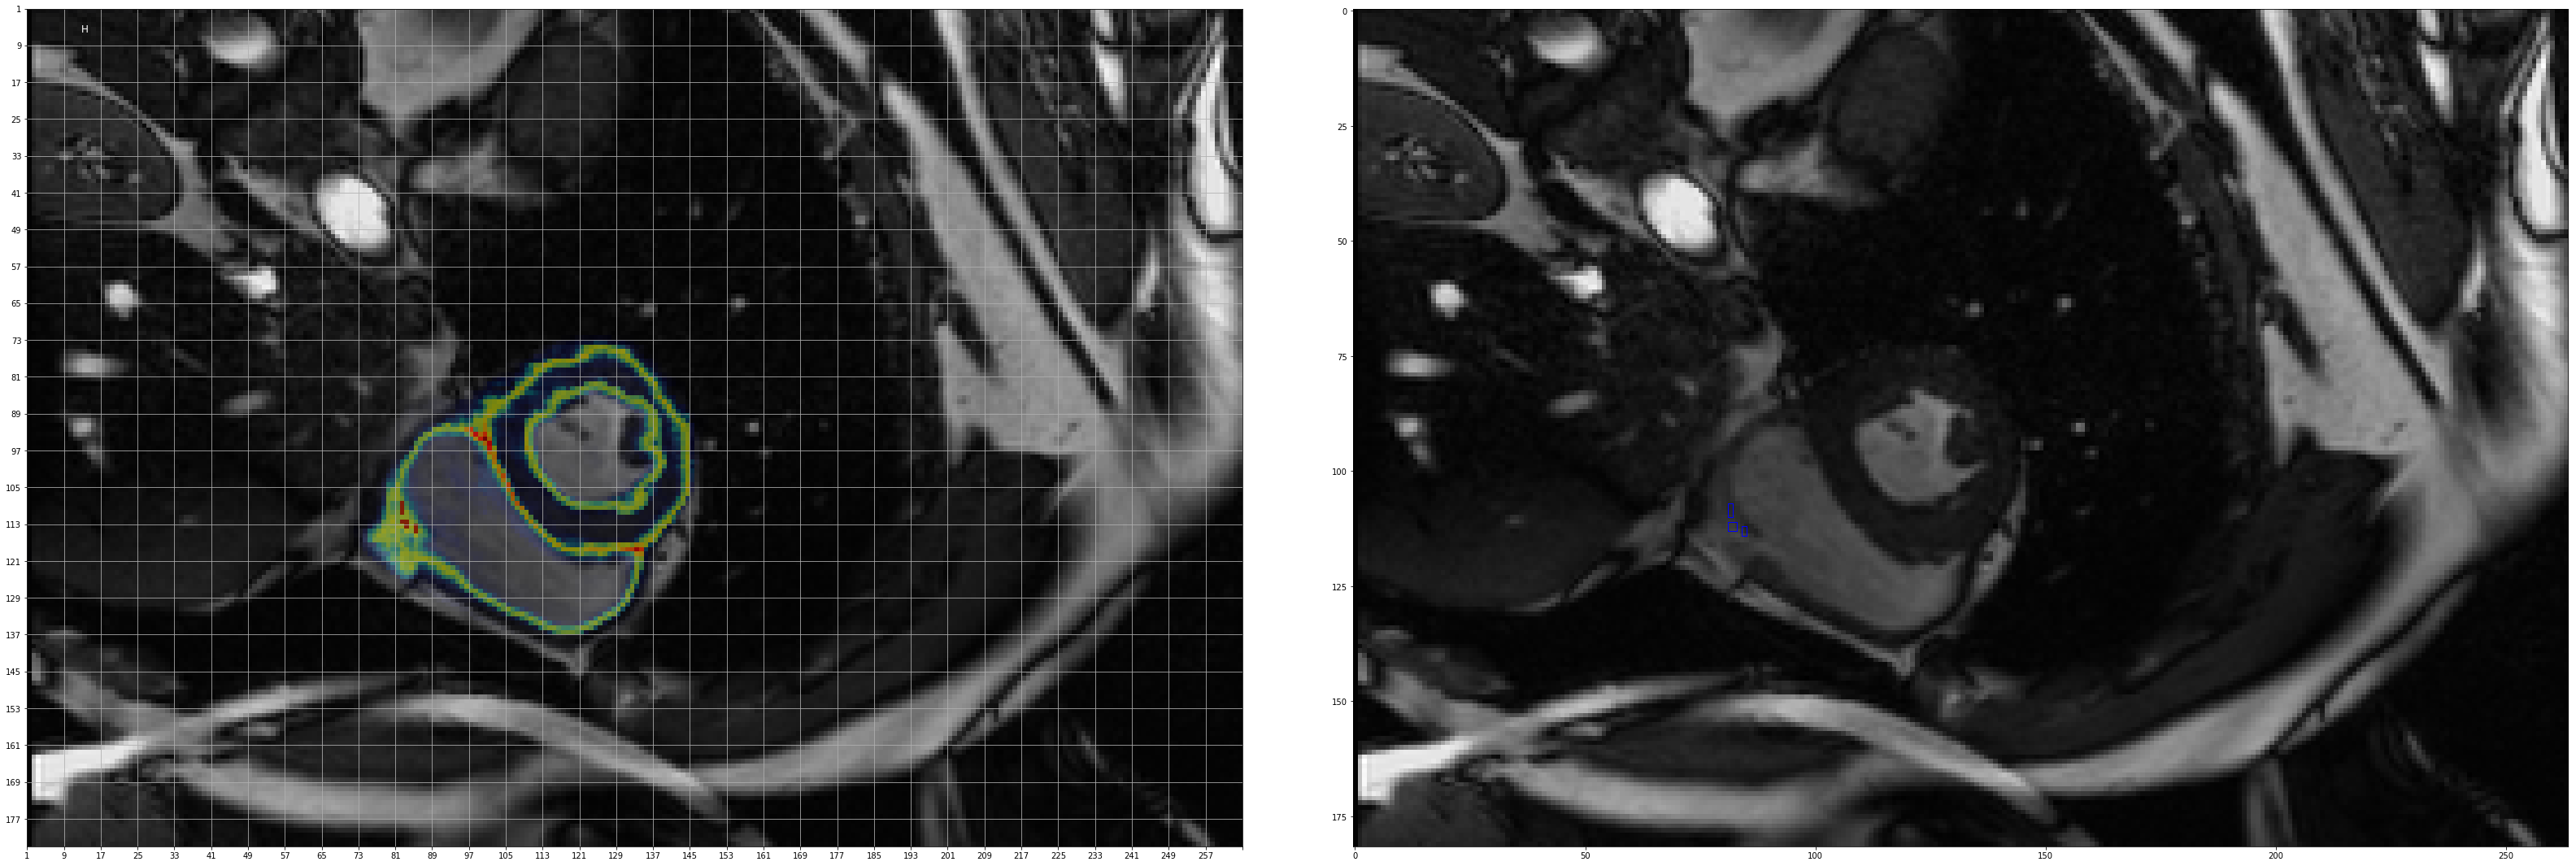

In [68]:
slice_num = 197
batch_nr = 1
image = dataset.train_images[slice_num]
label = dataset.train_labels[slice_num]
bbox = new_batch.batch_bounding_boxes[batch_nr]
bbox = BoundingBox.create(bbox)
print(bbox.box_four)
fig = plt.figure(figsize=(56, 50))

ax1 = plt.subplot2grid((2, 4), (0, 0), rowspan=2, colspan=2)
w, h = image[0].shape
ax1.imshow(image[0], cmap=cm.gray)
ax1.imshow(image[1], cmap=mycmap)
ax1.imshow(label, cmap=mycmap)

ax1.grid(which='minor', color='w', linestyle='-', linewidth=4)
ax1.set_xticks(np.arange(-.5, h, 8))
ax1.set_yticks(np.arange(-.5, w, 8))
ax1.set_xticklabels(np.arange(1, h+1, 8))
ax1.set_yticklabels(np.arange(1, w+1, 8))
ax1.text(12, 4, 'H', size='large',
            ha='center', va='center', color='w')
plt.grid(True)
# ax1.add_patch(bbox.get_matplotlib_patch(color='b'))
ax2 = plt.subplot2grid((2, 4), (0, 2), rowspan=2, colspan=2)
ax2.imshow(image[0], cmap=cm.gray)

for roi_idx in np.arange(dataset.train_lbl_rois[slice_num].shape[0]):
    box_four = dataset.train_lbl_rois[slice_num][roi_idx]
    roi_box = BoundingBox.create(box_four)
    ax2.add_patch(roi_box.get_matplotlib_patch(color='b'))

# ax1.imshow(center_mask, cmap=mycmap)
plt.show()

In [9]:
batch_size = 8
new_batch = BatchHandler(dataset, is_train=True, cuda=True, keep_bounding_boxes=True, verbose=False,
                         num_of_max_pool_layers=4)
batch_imgs, _target_labels_per_roi = new_batch(batch_size=batch_size)
print(new_batch.dataset_slice_ids)

[2733, 593, 453, 2758, 5144, 2864, 2340, 3337]


In [20]:
target_labels = new_batch.target_labels_per_roi
# this is a dict with keys 1, 4, 8
print(np.where(target_labels[8][0] !=0 ))

(array([20, 21, 29, 30, 40, 41, 42, 47, 48, 49, 50, 51, 56, 57, 58, 59, 65,
       66, 67, 68]),)


number_of_slices 30 height, width 240, 16


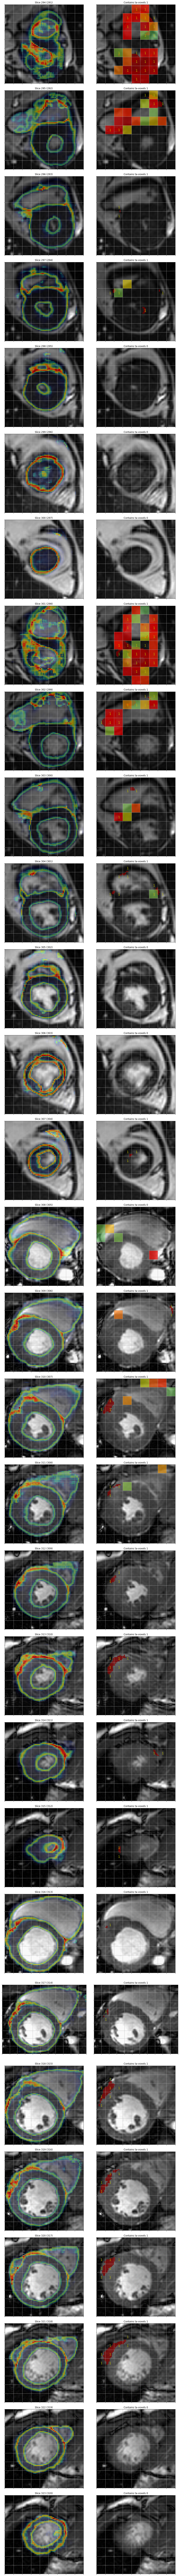

In [26]:
eval_batch.visualize_batch(grid_spacing=8, index_range=[290, 320])

In [4]:
from utils.detector.exper_handler import create_experiment

exper_id_rd2 = "20181016_11_49_37_rd2_f0p01_brier_emap_200KE_lr1e04"
exper_id_rd1 = "20181016_11_46_00_rd1_f0p01_brier_emap_200KE_lr1e04"
exper_id_rd2_bayes = "20181016_18_17_47_rd1_f0p01_brier_umap_200KE_lr1e04"
exper_id_rd3 = "20181023_12_10_48_rd3_f0_emap_brier_emap_50KE_lr1e05"

exp_handler = create_experiment(exper_id_rd3)



Load experiment from /home/jorg/repository/dcnn_acdc/logs/RD/20181023_12_10_48_rd3_f0_emap_brier_emap_50KE_lr1e05/stats/exper_stats.dll


In [5]:
rd_model = exp_handler.load_checkpoint(checkpoint=25000)

Creating new model RegionDetector: rd3-detector
INFO - RegionDetector - debug - num_of_channels_last_layer 128
INFO - RegionDetector - debug - total #parameters 140514


In [6]:
exp_handler.exper.config.get_architecture(model_name=exp_handler.exper.run_args.model)
eval_batch = exp_handler.eval(dataset, rd_model, eval_size=500, keep_batch=True, verbose=False)
eval_batch.fill_trans_dict()

('self.exper.config.num_of_max_pool ', 4)
('lbl_slice.shape ', (112, 96))
('len(label_patches) ', 168)
(8, 0, (168,))
(8, 1, (168,))
(8, 2, (168,))
(8, 3, (168,))
(8, 4, (168,))
(8, 5, (168,))
(8, 6, (168,))
(8, 7, (168,))
(8, 8, (168,))
(8, 9, (168,))
(8, 10, (168,))
(8, 11, (168,))
(8, 12, (168,))
(8, 13, (168,))
(8, 14, (168,))
(8, 15, (168,))
(8, 16, (168,))
(8, 17, (168,))
(8, 18, (168,))
(8, 19, (168,))
(8, 20, (168,))
(8, 21, (168,))
(8, 22, (168,))
(8, 23, (168,))
(8, 24, (168,))
(8, 25, (168,))
(8, 26, (168,))
(8, 27, (168,))
(8, 28, (168,))
(8, 29, (168,))
(8, 30, (168,))
(8, 31, (168,))
(8, 32, (168,))
(8, 33, (168,))
(8, 34, (168,))
(8, 35, (168,))
(8, 36, (168,))
(8, 37, (168,))
(8, 38, (168,))
(8, 39, (168,))
(8, 40, (168,))
(8, 41, (168,))
(8, 42, (168,))
(8, 43, (168,))
(8, 44, (168,))
(8, 45, (168,))
(8, 46, (168,))
(8, 47, (168,))
(8, 48, (168,))
(8, 49, (168,))
(8, 50, (168,))
(8, 51, (168,))
(8, 52, (168,))
(8, 53, (168,))
(8, 54, (168,))
(8, 55, (168,))
(8, 56, (16

(4, 358, (400,))
(4, 359, (400,))
(4, 360, (400,))
(4, 361, (400,))
(4, 362, (400,))
(4, 363, (400,))
(4, 364, (400,))
(4, 365, (400,))
(4, 366, (400,))
(4, 367, (400,))
(4, 368, (400,))
(4, 369, (400,))
(4, 370, (400,))
(4, 371, (400,))
(4, 372, (400,))
(4, 373, (400,))
(4, 374, (400,))
(4, 375, (400,))
(4, 376, (400,))
(4, 377, (400,))
(4, 378, (400,))
(4, 379, (400,))
(4, 380, (400,))
(4, 381, (400,))
(4, 382, (400,))
(4, 383, (400,))
(4, 384, (400,))
(4, 385, (400,))
(4, 386, (400,))
(4, 387, (400,))
(4, 388, (400,))
(4, 389, (400,))
(4, 390, (400,))
(4, 391, (400,))
(4, 392, (400,))
(4, 393, (400,))
(4, 394, (400,))
(4, 395, (400,))
(4, 396, (400,))
(4, 397, (400,))
(4, 398, (400,))
(4, 399, (400,))
('lbl_slice.shape ', (112, 112))
('len(label_patches) ', 196)
(8, 0, (196,))
(8, 1, (196,))
(8, 2, (196,))
(8, 3, (196,))
(8, 4, (196,))
(8, 5, (196,))
(8, 6, (196,))
(8, 7, (196,))
(8, 8, (196,))
(8, 9, (196,))
(8, 10, (196,))
(8, 11, (196,))
(8, 12, (196,))
(8, 13, (196,))
(8, 14, (1

('lbl_slice.shape ', (112, 80))
('len(label_patches) ', 140)
(8, 0, (140,))
(8, 1, (140,))
(8, 2, (140,))
(8, 3, (140,))
(8, 4, (140,))
(8, 5, (140,))
(8, 6, (140,))
(8, 7, (140,))
(8, 8, (140,))
(8, 9, (140,))
(8, 10, (140,))
(8, 11, (140,))
(8, 12, (140,))
(8, 13, (140,))
(8, 14, (140,))
(8, 15, (140,))
(8, 16, (140,))
(8, 17, (140,))
(8, 18, (140,))
(8, 19, (140,))
(8, 20, (140,))
(8, 21, (140,))
(8, 22, (140,))
(8, 23, (140,))
(8, 24, (140,))
(8, 25, (140,))
(8, 26, (140,))
(8, 27, (140,))
(8, 28, (140,))
(8, 29, (140,))
(8, 30, (140,))
(8, 31, (140,))
(8, 32, (140,))
(8, 33, (140,))
(8, 34, (140,))
(8, 35, (140,))
(8, 36, (140,))
(8, 37, (140,))
(8, 38, (140,))
(8, 39, (140,))
(8, 40, (140,))
(8, 41, (140,))
(8, 42, (140,))
(8, 43, (140,))
(8, 44, (140,))
(8, 45, (140,))
(8, 46, (140,))
(8, 47, (140,))
(8, 48, (140,))
(8, 49, (140,))
(8, 50, (140,))
(8, 51, (140,))
(8, 52, (140,))
(8, 53, (140,))
(8, 54, (140,))
(8, 55, (140,))
(8, 56, (140,))
(8, 57, (140,))
(8, 58, (140,))
(8, 5

(8, 27, (100,))
(8, 28, (100,))
(8, 29, (100,))
(8, 30, (100,))
(8, 31, (100,))
(8, 32, (100,))
(8, 33, (100,))
(8, 34, (100,))
(8, 35, (100,))
(8, 36, (100,))
(8, 37, (100,))
(8, 38, (100,))
(8, 39, (100,))
(8, 40, (100,))
(8, 41, (100,))
(8, 42, (100,))
(8, 43, (100,))
(8, 44, (100,))
(8, 45, (100,))
(8, 46, (100,))
(8, 47, (100,))
(8, 48, (100,))
(8, 49, (100,))
(8, 50, (100,))
(8, 51, (100,))
(8, 52, (100,))
(8, 53, (100,))
(8, 54, (100,))
(8, 55, (100,))
(8, 56, (100,))
(8, 57, (100,))
(8, 58, (100,))
(8, 59, (100,))
(8, 60, (100,))
(8, 61, (100,))
(8, 62, (100,))
(8, 63, (100,))
(8, 64, (100,))
(8, 65, (100,))
(8, 66, (100,))
(8, 67, (100,))
(8, 68, (100,))
(8, 69, (100,))
(8, 70, (100,))
(8, 71, (100,))
(8, 72, (100,))
(8, 73, (100,))
(8, 74, (100,))
(8, 75, (100,))
(8, 76, (100,))
(8, 77, (100,))
(8, 78, (100,))
(8, 79, (100,))
(8, 80, (100,))
(8, 81, (100,))
(8, 82, (100,))
(8, 83, (100,))
(8, 84, (100,))
(8, 85, (100,))
(8, 86, (100,))
(8, 87, (100,))
(8, 88, (100,))
(8, 89, 

(4, 279, (400,))
(4, 280, (400,))
(4, 281, (400,))
(4, 282, (400,))
(4, 283, (400,))
(4, 284, (400,))
(4, 285, (400,))
(4, 286, (400,))
(4, 287, (400,))
(4, 288, (400,))
(4, 289, (400,))
(4, 290, (400,))
(4, 291, (400,))
(4, 292, (400,))
(4, 293, (400,))
(4, 294, (400,))
(4, 295, (400,))
(4, 296, (400,))
(4, 297, (400,))
(4, 298, (400,))
(4, 299, (400,))
(4, 300, (400,))
(4, 301, (400,))
(4, 302, (400,))
(4, 303, (400,))
(4, 304, (400,))
(4, 305, (400,))
(4, 306, (400,))
(4, 307, (400,))
(4, 308, (400,))
(4, 309, (400,))
(4, 310, (400,))
(4, 311, (400,))
(4, 312, (400,))
(4, 313, (400,))
(4, 314, (400,))
(4, 315, (400,))
(4, 316, (400,))
(4, 317, (400,))
(4, 318, (400,))
(4, 319, (400,))
(4, 320, (400,))
(4, 321, (400,))
(4, 322, (400,))
(4, 323, (400,))
(4, 324, (400,))
(4, 325, (400,))
(4, 326, (400,))
(4, 327, (400,))
(4, 328, (400,))
(4, 329, (400,))
(4, 330, (400,))
(4, 331, (400,))
(4, 332, (400,))
(4, 333, (400,))
(4, 334, (400,))
(4, 335, (400,))
(4, 336, (400,))
(4, 337, (400,

(8, 88, (100,))
(8, 89, (100,))
(8, 90, (100,))
(8, 91, (100,))
(8, 92, (100,))
(8, 93, (100,))
(8, 94, (100,))
(8, 95, (100,))
(8, 96, (100,))
(8, 97, (100,))
(8, 98, (100,))
(8, 99, (100,))
('len(label_patches) ', 25)
(16, 0, (25,))
(16, 1, (25,))
(16, 2, (25,))
(16, 3, (25,))
(16, 4, (25,))
(16, 5, (25,))
(16, 6, (25,))
(16, 7, (25,))
(16, 8, (25,))
(16, 9, (25,))
(16, 10, (25,))
(16, 11, (25,))
(16, 12, (25,))
(16, 13, (25,))
(16, 14, (25,))
(16, 15, (25,))
(16, 16, (25,))
(16, 17, (25,))
(16, 18, (25,))
(16, 19, (25,))
(16, 20, (25,))
(16, 21, (25,))
(16, 22, (25,))
(16, 23, (25,))
(16, 24, (25,))
('len(label_patches) ', 400)
(4, 0, (400,))
(4, 1, (400,))
(4, 2, (400,))
(4, 3, (400,))
(4, 4, (400,))
(4, 5, (400,))
(4, 6, (400,))
(4, 7, (400,))
(4, 8, (400,))
(4, 9, (400,))
(4, 10, (400,))
(4, 11, (400,))
(4, 12, (400,))
(4, 13, (400,))
(4, 14, (400,))
(4, 15, (400,))
(4, 16, (400,))
(4, 17, (400,))
(4, 18, (400,))
(4, 19, (400,))
(4, 20, (400,))
(4, 21, (400,))
(4, 22, (400,))
(4,

(4, 193, (400,))
(4, 194, (400,))
(4, 195, (400,))
(4, 196, (400,))
(4, 197, (400,))
(4, 198, (400,))
(4, 199, (400,))
(4, 200, (400,))
(4, 201, (400,))
(4, 202, (400,))
(4, 203, (400,))
(4, 204, (400,))
(4, 205, (400,))
(4, 206, (400,))
(4, 207, (400,))
(4, 208, (400,))
(4, 209, (400,))
(4, 210, (400,))
(4, 211, (400,))
(4, 212, (400,))
(4, 213, (400,))
(4, 214, (400,))
(4, 215, (400,))
(4, 216, (400,))
(4, 217, (400,))
(4, 218, (400,))
(4, 219, (400,))
(4, 220, (400,))
(4, 221, (400,))
(4, 222, (400,))
(4, 223, (400,))
(4, 224, (400,))
(4, 225, (400,))
(4, 226, (400,))
(4, 227, (400,))
(4, 228, (400,))
(4, 229, (400,))
(4, 230, (400,))
(4, 231, (400,))
(4, 232, (400,))
(4, 233, (400,))
(4, 234, (400,))
(4, 235, (400,))
(4, 236, (400,))
(4, 237, (400,))
(4, 238, (400,))
(4, 239, (400,))
(4, 240, (400,))
(4, 241, (400,))
(4, 242, (400,))
(4, 243, (400,))
(4, 244, (400,))
(4, 245, (400,))
(4, 246, (400,))
(4, 247, (400,))
(4, 248, (400,))
(4, 249, (400,))
(4, 250, (400,))
(4, 251, (400,

(8, 28, (100,))
(8, 29, (100,))
(8, 30, (100,))
(8, 31, (100,))
(8, 32, (100,))
(8, 33, (100,))
(8, 34, (100,))
(8, 35, (100,))
(8, 36, (100,))
(8, 37, (100,))
(8, 38, (100,))
(8, 39, (100,))
(8, 40, (100,))
(8, 41, (100,))
(8, 42, (100,))
(8, 43, (100,))
(8, 44, (100,))
(8, 45, (100,))
(8, 46, (100,))
(8, 47, (100,))
(8, 48, (100,))
(8, 49, (100,))
(8, 50, (100,))
(8, 51, (100,))
(8, 52, (100,))
(8, 53, (100,))
(8, 54, (100,))
(8, 55, (100,))
(8, 56, (100,))
(8, 57, (100,))
(8, 58, (100,))
(8, 59, (100,))
(8, 60, (100,))
(8, 61, (100,))
(8, 62, (100,))
(8, 63, (100,))
(8, 64, (100,))
(8, 65, (100,))
(8, 66, (100,))
(8, 67, (100,))
(8, 68, (100,))
(8, 69, (100,))
(8, 70, (100,))
(8, 71, (100,))
(8, 72, (100,))
(8, 73, (100,))
(8, 74, (100,))
(8, 75, (100,))
(8, 76, (100,))
(8, 77, (100,))
(8, 78, (100,))
(8, 79, (100,))
(8, 80, (100,))
(8, 81, (100,))
(8, 82, (100,))
(8, 83, (100,))
(8, 84, (100,))
(8, 85, (100,))
(8, 86, (100,))
(8, 87, (100,))
(8, 88, (100,))
(8, 89, (100,))
(8, 90, 

('lbl_slice.shape ', (80, 80))
('len(label_patches) ', 100)
(8, 0, (100,))
(8, 1, (100,))
(8, 2, (100,))
(8, 3, (100,))
(8, 4, (100,))
(8, 5, (100,))
(8, 6, (100,))
(8, 7, (100,))
(8, 8, (100,))
(8, 9, (100,))
(8, 10, (100,))
(8, 11, (100,))
(8, 12, (100,))
(8, 13, (100,))
(8, 14, (100,))
(8, 15, (100,))
(8, 16, (100,))
(8, 17, (100,))
(8, 18, (100,))
(8, 19, (100,))
(8, 20, (100,))
(8, 21, (100,))
(8, 22, (100,))
(8, 23, (100,))
(8, 24, (100,))
(8, 25, (100,))
(8, 26, (100,))
(8, 27, (100,))
(8, 28, (100,))
(8, 29, (100,))
(8, 30, (100,))
(8, 31, (100,))
(8, 32, (100,))
(8, 33, (100,))
(8, 34, (100,))
(8, 35, (100,))
(8, 36, (100,))
(8, 37, (100,))
(8, 38, (100,))
(8, 39, (100,))
(8, 40, (100,))
(8, 41, (100,))
(8, 42, (100,))
(8, 43, (100,))
(8, 44, (100,))
(8, 45, (100,))
(8, 46, (100,))
(8, 47, (100,))
(8, 48, (100,))
(8, 49, (100,))
(8, 50, (100,))
(8, 51, (100,))
(8, 52, (100,))
(8, 53, (100,))
(8, 54, (100,))
(8, 55, (100,))
(8, 56, (100,))
(8, 57, (100,))
(8, 58, (100,))
(8, 59

(8, 6, (100,))
(8, 7, (100,))
(8, 8, (100,))
(8, 9, (100,))
(8, 10, (100,))
(8, 11, (100,))
(8, 12, (100,))
(8, 13, (100,))
(8, 14, (100,))
(8, 15, (100,))
(8, 16, (100,))
(8, 17, (100,))
(8, 18, (100,))
(8, 19, (100,))
(8, 20, (100,))
(8, 21, (100,))
(8, 22, (100,))
(8, 23, (100,))
(8, 24, (100,))
(8, 25, (100,))
(8, 26, (100,))
(8, 27, (100,))
(8, 28, (100,))
(8, 29, (100,))
(8, 30, (100,))
(8, 31, (100,))
(8, 32, (100,))
(8, 33, (100,))
(8, 34, (100,))
(8, 35, (100,))
(8, 36, (100,))
(8, 37, (100,))
(8, 38, (100,))
(8, 39, (100,))
(8, 40, (100,))
(8, 41, (100,))
(8, 42, (100,))
(8, 43, (100,))
(8, 44, (100,))
(8, 45, (100,))
(8, 46, (100,))
(8, 47, (100,))
(8, 48, (100,))
(8, 49, (100,))
(8, 50, (100,))
(8, 51, (100,))
(8, 52, (100,))
(8, 53, (100,))
(8, 54, (100,))
(8, 55, (100,))
(8, 56, (100,))
(8, 57, (100,))
(8, 58, (100,))
(8, 59, (100,))
(8, 60, (100,))
(8, 61, (100,))
(8, 62, (100,))
(8, 63, (100,))
(8, 64, (100,))
(8, 65, (100,))
(8, 66, (100,))
(8, 67, (100,))
(8, 68, (100

(4, 254, (400,))
(4, 255, (400,))
(4, 256, (400,))
(4, 257, (400,))
(4, 258, (400,))
(4, 259, (400,))
(4, 260, (400,))
(4, 261, (400,))
(4, 262, (400,))
(4, 263, (400,))
(4, 264, (400,))
(4, 265, (400,))
(4, 266, (400,))
(4, 267, (400,))
(4, 268, (400,))
(4, 269, (400,))
(4, 270, (400,))
(4, 271, (400,))
(4, 272, (400,))
(4, 273, (400,))
(4, 274, (400,))
(4, 275, (400,))
(4, 276, (400,))
(4, 277, (400,))
(4, 278, (400,))
(4, 279, (400,))
(4, 280, (400,))
(4, 281, (400,))
(4, 282, (400,))
(4, 283, (400,))
(4, 284, (400,))
(4, 285, (400,))
(4, 286, (400,))
(4, 287, (400,))
(4, 288, (400,))
(4, 289, (400,))
(4, 290, (400,))
(4, 291, (400,))
(4, 292, (400,))
(4, 293, (400,))
(4, 294, (400,))
(4, 295, (400,))
(4, 296, (400,))
(4, 297, (400,))
(4, 298, (400,))
(4, 299, (400,))
(4, 300, (400,))
(4, 301, (400,))
(4, 302, (400,))
(4, 303, (400,))
(4, 304, (400,))
(4, 305, (400,))
(4, 306, (400,))
(4, 307, (400,))
(4, 308, (400,))
(4, 309, (400,))
(4, 310, (400,))
(4, 311, (400,))
(4, 312, (400,

(4, 80, (400,))
(4, 81, (400,))
(4, 82, (400,))
(4, 83, (400,))
(4, 84, (400,))
(4, 85, (400,))
(4, 86, (400,))
(4, 87, (400,))
(4, 88, (400,))
(4, 89, (400,))
(4, 90, (400,))
(4, 91, (400,))
(4, 92, (400,))
(4, 93, (400,))
(4, 94, (400,))
(4, 95, (400,))
(4, 96, (400,))
(4, 97, (400,))
(4, 98, (400,))
(4, 99, (400,))
(4, 100, (400,))
(4, 101, (400,))
(4, 102, (400,))
(4, 103, (400,))
(4, 104, (400,))
(4, 105, (400,))
(4, 106, (400,))
(4, 107, (400,))
(4, 108, (400,))
(4, 109, (400,))
(4, 110, (400,))
(4, 111, (400,))
(4, 112, (400,))
(4, 113, (400,))
(4, 114, (400,))
(4, 115, (400,))
(4, 116, (400,))
(4, 117, (400,))
(4, 118, (400,))
(4, 119, (400,))
(4, 120, (400,))
(4, 121, (400,))
(4, 122, (400,))
(4, 123, (400,))
(4, 124, (400,))
(4, 125, (400,))
(4, 126, (400,))
(4, 127, (400,))
(4, 128, (400,))
(4, 129, (400,))
(4, 130, (400,))
(4, 131, (400,))
(4, 132, (400,))
(4, 133, (400,))
(4, 134, (400,))
(4, 135, (400,))
(4, 136, (400,))
(4, 137, (400,))
(4, 138, (400,))
(4, 139, (400,))


(4, 281, (400,))
(4, 282, (400,))
(4, 283, (400,))
(4, 284, (400,))
(4, 285, (400,))
(4, 286, (400,))
(4, 287, (400,))
(4, 288, (400,))
(4, 289, (400,))
(4, 290, (400,))
(4, 291, (400,))
(4, 292, (400,))
(4, 293, (400,))
(4, 294, (400,))
(4, 295, (400,))
(4, 296, (400,))
(4, 297, (400,))
(4, 298, (400,))
(4, 299, (400,))
(4, 300, (400,))
(4, 301, (400,))
(4, 302, (400,))
(4, 303, (400,))
(4, 304, (400,))
(4, 305, (400,))
(4, 306, (400,))
(4, 307, (400,))
(4, 308, (400,))
(4, 309, (400,))
(4, 310, (400,))
(4, 311, (400,))
(4, 312, (400,))
(4, 313, (400,))
(4, 314, (400,))
(4, 315, (400,))
(4, 316, (400,))
(4, 317, (400,))
(4, 318, (400,))
(4, 319, (400,))
(4, 320, (400,))
(4, 321, (400,))
(4, 322, (400,))
(4, 323, (400,))
(4, 324, (400,))
(4, 325, (400,))
(4, 326, (400,))
(4, 327, (400,))
(4, 328, (400,))
(4, 329, (400,))
(4, 330, (400,))
(4, 331, (400,))
(4, 332, (400,))
(4, 333, (400,))
(4, 334, (400,))
(4, 335, (400,))
(4, 336, (400,))
(4, 337, (400,))
(4, 338, (400,))
(4, 339, (400,

(4, 348, (560,))
(4, 349, (560,))
(4, 350, (560,))
(4, 351, (560,))
(4, 352, (560,))
(4, 353, (560,))
(4, 354, (560,))
(4, 355, (560,))
(4, 356, (560,))
(4, 357, (560,))
(4, 358, (560,))
(4, 359, (560,))
(4, 360, (560,))
(4, 361, (560,))
(4, 362, (560,))
(4, 363, (560,))
(4, 364, (560,))
(4, 365, (560,))
(4, 366, (560,))
(4, 367, (560,))
(4, 368, (560,))
(4, 369, (560,))
(4, 370, (560,))
(4, 371, (560,))
(4, 372, (560,))
(4, 373, (560,))
(4, 374, (560,))
(4, 375, (560,))
(4, 376, (560,))
(4, 377, (560,))
(4, 378, (560,))
(4, 379, (560,))
(4, 380, (560,))
(4, 381, (560,))
(4, 382, (560,))
(4, 383, (560,))
(4, 384, (560,))
(4, 385, (560,))
(4, 386, (560,))
(4, 387, (560,))
(4, 388, (560,))
(4, 389, (560,))
(4, 390, (560,))
(4, 391, (560,))
(4, 392, (560,))
(4, 393, (560,))
(4, 394, (560,))
(4, 395, (560,))
(4, 396, (560,))
(4, 397, (560,))
(4, 398, (560,))
(4, 399, (560,))
(4, 400, (560,))
(4, 401, (560,))
(4, 402, (560,))
(4, 403, (560,))
(4, 404, (560,))
(4, 405, (560,))
(4, 406, (560,

(4, 108, (400,))
(4, 109, (400,))
(4, 110, (400,))
(4, 111, (400,))
(4, 112, (400,))
(4, 113, (400,))
(4, 114, (400,))
(4, 115, (400,))
(4, 116, (400,))
(4, 117, (400,))
(4, 118, (400,))
(4, 119, (400,))
(4, 120, (400,))
(4, 121, (400,))
(4, 122, (400,))
(4, 123, (400,))
(4, 124, (400,))
(4, 125, (400,))
(4, 126, (400,))
(4, 127, (400,))
(4, 128, (400,))
(4, 129, (400,))
(4, 130, (400,))
(4, 131, (400,))
(4, 132, (400,))
(4, 133, (400,))
(4, 134, (400,))
(4, 135, (400,))
(4, 136, (400,))
(4, 137, (400,))
(4, 138, (400,))
(4, 139, (400,))
(4, 140, (400,))
(4, 141, (400,))
(4, 142, (400,))
(4, 143, (400,))
(4, 144, (400,))
(4, 145, (400,))
(4, 146, (400,))
(4, 147, (400,))
(4, 148, (400,))
(4, 149, (400,))
(4, 150, (400,))
(4, 151, (400,))
(4, 152, (400,))
(4, 153, (400,))
(4, 154, (400,))
(4, 155, (400,))
(4, 156, (400,))
(4, 157, (400,))
(4, 158, (400,))
(4, 159, (400,))
(4, 160, (400,))
(4, 161, (400,))
(4, 162, (400,))
(4, 163, (400,))
(4, 164, (400,))
(4, 165, (400,))
(4, 166, (400,

(4, 40, (400,))
(4, 41, (400,))
(4, 42, (400,))
(4, 43, (400,))
(4, 44, (400,))
(4, 45, (400,))
(4, 46, (400,))
(4, 47, (400,))
(4, 48, (400,))
(4, 49, (400,))
(4, 50, (400,))
(4, 51, (400,))
(4, 52, (400,))
(4, 53, (400,))
(4, 54, (400,))
(4, 55, (400,))
(4, 56, (400,))
(4, 57, (400,))
(4, 58, (400,))
(4, 59, (400,))
(4, 60, (400,))
(4, 61, (400,))
(4, 62, (400,))
(4, 63, (400,))
(4, 64, (400,))
(4, 65, (400,))
(4, 66, (400,))
(4, 67, (400,))
(4, 68, (400,))
(4, 69, (400,))
(4, 70, (400,))
(4, 71, (400,))
(4, 72, (400,))
(4, 73, (400,))
(4, 74, (400,))
(4, 75, (400,))
(4, 76, (400,))
(4, 77, (400,))
(4, 78, (400,))
(4, 79, (400,))
(4, 80, (400,))
(4, 81, (400,))
(4, 82, (400,))
(4, 83, (400,))
(4, 84, (400,))
(4, 85, (400,))
(4, 86, (400,))
(4, 87, (400,))
(4, 88, (400,))
(4, 89, (400,))
(4, 90, (400,))
(4, 91, (400,))
(4, 92, (400,))
(4, 93, (400,))
(4, 94, (400,))
(4, 95, (400,))
(4, 96, (400,))
(4, 97, (400,))
(4, 98, (400,))
(4, 99, (400,))
(4, 100, (400,))
(4, 101, (400,))
(4, 10

(4, 222, (400,))
(4, 223, (400,))
(4, 224, (400,))
(4, 225, (400,))
(4, 226, (400,))
(4, 227, (400,))
(4, 228, (400,))
(4, 229, (400,))
(4, 230, (400,))
(4, 231, (400,))
(4, 232, (400,))
(4, 233, (400,))
(4, 234, (400,))
(4, 235, (400,))
(4, 236, (400,))
(4, 237, (400,))
(4, 238, (400,))
(4, 239, (400,))
(4, 240, (400,))
(4, 241, (400,))
(4, 242, (400,))
(4, 243, (400,))
(4, 244, (400,))
(4, 245, (400,))
(4, 246, (400,))
(4, 247, (400,))
(4, 248, (400,))
(4, 249, (400,))
(4, 250, (400,))
(4, 251, (400,))
(4, 252, (400,))
(4, 253, (400,))
(4, 254, (400,))
(4, 255, (400,))
(4, 256, (400,))
(4, 257, (400,))
(4, 258, (400,))
(4, 259, (400,))
(4, 260, (400,))
(4, 261, (400,))
(4, 262, (400,))
(4, 263, (400,))
(4, 264, (400,))
(4, 265, (400,))
(4, 266, (400,))
(4, 267, (400,))
(4, 268, (400,))
(4, 269, (400,))
(4, 270, (400,))
(4, 271, (400,))
(4, 272, (400,))
(4, 273, (400,))
(4, 274, (400,))
(4, 275, (400,))
(4, 276, (400,))
(4, 277, (400,))
(4, 278, (400,))
(4, 279, (400,))
(4, 280, (400,

(4, 282, (400,))
(4, 283, (400,))
(4, 284, (400,))
(4, 285, (400,))
(4, 286, (400,))
(4, 287, (400,))
(4, 288, (400,))
(4, 289, (400,))
(4, 290, (400,))
(4, 291, (400,))
(4, 292, (400,))
(4, 293, (400,))
(4, 294, (400,))
(4, 295, (400,))
(4, 296, (400,))
(4, 297, (400,))
(4, 298, (400,))
(4, 299, (400,))
(4, 300, (400,))
(4, 301, (400,))
(4, 302, (400,))
(4, 303, (400,))
(4, 304, (400,))
(4, 305, (400,))
(4, 306, (400,))
(4, 307, (400,))
(4, 308, (400,))
(4, 309, (400,))
(4, 310, (400,))
(4, 311, (400,))
(4, 312, (400,))
(4, 313, (400,))
(4, 314, (400,))
(4, 315, (400,))
(4, 316, (400,))
(4, 317, (400,))
(4, 318, (400,))
(4, 319, (400,))
(4, 320, (400,))
(4, 321, (400,))
(4, 322, (400,))
(4, 323, (400,))
(4, 324, (400,))
(4, 325, (400,))
(4, 326, (400,))
(4, 327, (400,))
(4, 328, (400,))
(4, 329, (400,))
(4, 330, (400,))
(4, 331, (400,))
(4, 332, (400,))
(4, 333, (400,))
(4, 334, (400,))
(4, 335, (400,))
(4, 336, (400,))
(4, 337, (400,))
(4, 338, (400,))
(4, 339, (400,))
(4, 340, (400,

(16, 16, (25,))
(16, 17, (25,))
(16, 18, (25,))
(16, 19, (25,))
(16, 20, (25,))
(16, 21, (25,))
(16, 22, (25,))
(16, 23, (25,))
(16, 24, (25,))
('len(label_patches) ', 400)
(4, 0, (400,))
(4, 1, (400,))
(4, 2, (400,))
(4, 3, (400,))
(4, 4, (400,))
(4, 5, (400,))
(4, 6, (400,))
(4, 7, (400,))
(4, 8, (400,))
(4, 9, (400,))
(4, 10, (400,))
(4, 11, (400,))
(4, 12, (400,))
(4, 13, (400,))
(4, 14, (400,))
(4, 15, (400,))
(4, 16, (400,))
(4, 17, (400,))
(4, 18, (400,))
(4, 19, (400,))
(4, 20, (400,))
(4, 21, (400,))
(4, 22, (400,))
(4, 23, (400,))
(4, 24, (400,))
(4, 25, (400,))
(4, 26, (400,))
(4, 27, (400,))
(4, 28, (400,))
(4, 29, (400,))
(4, 30, (400,))
(4, 31, (400,))
(4, 32, (400,))
(4, 33, (400,))
(4, 34, (400,))
(4, 35, (400,))
(4, 36, (400,))
(4, 37, (400,))
(4, 38, (400,))
(4, 39, (400,))
(4, 40, (400,))
(4, 41, (400,))
(4, 42, (400,))
(4, 43, (400,))
(4, 44, (400,))
(4, 45, (400,))
(4, 46, (400,))
(4, 47, (400,))
(4, 48, (400,))
(4, 49, (400,))
(4, 50, (400,))
(4, 51, (400,))
(4, 5

(4, 7, (400,))
(4, 8, (400,))
(4, 9, (400,))
(4, 10, (400,))
(4, 11, (400,))
(4, 12, (400,))
(4, 13, (400,))
(4, 14, (400,))
(4, 15, (400,))
(4, 16, (400,))
(4, 17, (400,))
(4, 18, (400,))
(4, 19, (400,))
(4, 20, (400,))
(4, 21, (400,))
(4, 22, (400,))
(4, 23, (400,))
(4, 24, (400,))
(4, 25, (400,))
(4, 26, (400,))
(4, 27, (400,))
(4, 28, (400,))
(4, 29, (400,))
(4, 30, (400,))
(4, 31, (400,))
(4, 32, (400,))
(4, 33, (400,))
(4, 34, (400,))
(4, 35, (400,))
(4, 36, (400,))
(4, 37, (400,))
(4, 38, (400,))
(4, 39, (400,))
(4, 40, (400,))
(4, 41, (400,))
(4, 42, (400,))
(4, 43, (400,))
(4, 44, (400,))
(4, 45, (400,))
(4, 46, (400,))
(4, 47, (400,))
(4, 48, (400,))
(4, 49, (400,))
(4, 50, (400,))
(4, 51, (400,))
(4, 52, (400,))
(4, 53, (400,))
(4, 54, (400,))
(4, 55, (400,))
(4, 56, (400,))
(4, 57, (400,))
(4, 58, (400,))
(4, 59, (400,))
(4, 60, (400,))
(4, 61, (400,))
(4, 62, (400,))
(4, 63, (400,))
(4, 64, (400,))
(4, 65, (400,))
(4, 66, (400,))
(4, 67, (400,))
(4, 68, (400,))
(4, 69, (40

(4, 111, (400,))
(4, 112, (400,))
(4, 113, (400,))
(4, 114, (400,))
(4, 115, (400,))
(4, 116, (400,))
(4, 117, (400,))
(4, 118, (400,))
(4, 119, (400,))
(4, 120, (400,))
(4, 121, (400,))
(4, 122, (400,))
(4, 123, (400,))
(4, 124, (400,))
(4, 125, (400,))
(4, 126, (400,))
(4, 127, (400,))
(4, 128, (400,))
(4, 129, (400,))
(4, 130, (400,))
(4, 131, (400,))
(4, 132, (400,))
(4, 133, (400,))
(4, 134, (400,))
(4, 135, (400,))
(4, 136, (400,))
(4, 137, (400,))
(4, 138, (400,))
(4, 139, (400,))
(4, 140, (400,))
(4, 141, (400,))
(4, 142, (400,))
(4, 143, (400,))
(4, 144, (400,))
(4, 145, (400,))
(4, 146, (400,))
(4, 147, (400,))
(4, 148, (400,))
(4, 149, (400,))
(4, 150, (400,))
(4, 151, (400,))
(4, 152, (400,))
(4, 153, (400,))
(4, 154, (400,))
(4, 155, (400,))
(4, 156, (400,))
(4, 157, (400,))
(4, 158, (400,))
(4, 159, (400,))
(4, 160, (400,))
(4, 161, (400,))
(4, 162, (400,))
(4, 163, (400,))
(4, 164, (400,))
(4, 165, (400,))
(4, 166, (400,))
(4, 167, (400,))
(4, 168, (400,))
(4, 169, (400,

(4, 288, (400,))
(4, 289, (400,))
(4, 290, (400,))
(4, 291, (400,))
(4, 292, (400,))
(4, 293, (400,))
(4, 294, (400,))
(4, 295, (400,))
(4, 296, (400,))
(4, 297, (400,))
(4, 298, (400,))
(4, 299, (400,))
(4, 300, (400,))
(4, 301, (400,))
(4, 302, (400,))
(4, 303, (400,))
(4, 304, (400,))
(4, 305, (400,))
(4, 306, (400,))
(4, 307, (400,))
(4, 308, (400,))
(4, 309, (400,))
(4, 310, (400,))
(4, 311, (400,))
(4, 312, (400,))
(4, 313, (400,))
(4, 314, (400,))
(4, 315, (400,))
(4, 316, (400,))
(4, 317, (400,))
(4, 318, (400,))
(4, 319, (400,))
(4, 320, (400,))
(4, 321, (400,))
(4, 322, (400,))
(4, 323, (400,))
(4, 324, (400,))
(4, 325, (400,))
(4, 326, (400,))
(4, 327, (400,))
(4, 328, (400,))
(4, 329, (400,))
(4, 330, (400,))
(4, 331, (400,))
(4, 332, (400,))
(4, 333, (400,))
(4, 334, (400,))
(4, 335, (400,))
(4, 336, (400,))
(4, 337, (400,))
(4, 338, (400,))
(4, 339, (400,))
(4, 340, (400,))
(4, 341, (400,))
(4, 342, (400,))
(4, 343, (400,))
(4, 344, (400,))
(4, 345, (400,))
(4, 346, (400,

(4, 35, (400,))
(4, 36, (400,))
(4, 37, (400,))
(4, 38, (400,))
(4, 39, (400,))
(4, 40, (400,))
(4, 41, (400,))
(4, 42, (400,))
(4, 43, (400,))
(4, 44, (400,))
(4, 45, (400,))
(4, 46, (400,))
(4, 47, (400,))
(4, 48, (400,))
(4, 49, (400,))
(4, 50, (400,))
(4, 51, (400,))
(4, 52, (400,))
(4, 53, (400,))
(4, 54, (400,))
(4, 55, (400,))
(4, 56, (400,))
(4, 57, (400,))
(4, 58, (400,))
(4, 59, (400,))
(4, 60, (400,))
(4, 61, (400,))
(4, 62, (400,))
(4, 63, (400,))
(4, 64, (400,))
(4, 65, (400,))
(4, 66, (400,))
(4, 67, (400,))
(4, 68, (400,))
(4, 69, (400,))
(4, 70, (400,))
(4, 71, (400,))
(4, 72, (400,))
(4, 73, (400,))
(4, 74, (400,))
(4, 75, (400,))
(4, 76, (400,))
(4, 77, (400,))
(4, 78, (400,))
(4, 79, (400,))
(4, 80, (400,))
(4, 81, (400,))
(4, 82, (400,))
(4, 83, (400,))
(4, 84, (400,))
(4, 85, (400,))
(4, 86, (400,))
(4, 87, (400,))
(4, 88, (400,))
(4, 89, (400,))
(4, 90, (400,))
(4, 91, (400,))
(4, 92, (400,))
(4, 93, (400,))
(4, 94, (400,))
(4, 95, (400,))
(4, 96, (400,))
(4, 97, 

(4, 88, (400,))
(4, 89, (400,))
(4, 90, (400,))
(4, 91, (400,))
(4, 92, (400,))
(4, 93, (400,))
(4, 94, (400,))
(4, 95, (400,))
(4, 96, (400,))
(4, 97, (400,))
(4, 98, (400,))
(4, 99, (400,))
(4, 100, (400,))
(4, 101, (400,))
(4, 102, (400,))
(4, 103, (400,))
(4, 104, (400,))
(4, 105, (400,))
(4, 106, (400,))
(4, 107, (400,))
(4, 108, (400,))
(4, 109, (400,))
(4, 110, (400,))
(4, 111, (400,))
(4, 112, (400,))
(4, 113, (400,))
(4, 114, (400,))
(4, 115, (400,))
(4, 116, (400,))
(4, 117, (400,))
(4, 118, (400,))
(4, 119, (400,))
(4, 120, (400,))
(4, 121, (400,))
(4, 122, (400,))
(4, 123, (400,))
(4, 124, (400,))
(4, 125, (400,))
(4, 126, (400,))
(4, 127, (400,))
(4, 128, (400,))
(4, 129, (400,))
(4, 130, (400,))
(4, 131, (400,))
(4, 132, (400,))
(4, 133, (400,))
(4, 134, (400,))
(4, 135, (400,))
(4, 136, (400,))
(4, 137, (400,))
(4, 138, (400,))
(4, 139, (400,))
(4, 140, (400,))
(4, 141, (400,))
(4, 142, (400,))
(4, 143, (400,))
(4, 144, (400,))
(4, 145, (400,))
(4, 146, (400,))
(4, 147, 

(4, 302, (400,))
(4, 303, (400,))
(4, 304, (400,))
(4, 305, (400,))
(4, 306, (400,))
(4, 307, (400,))
(4, 308, (400,))
(4, 309, (400,))
(4, 310, (400,))
(4, 311, (400,))
(4, 312, (400,))
(4, 313, (400,))
(4, 314, (400,))
(4, 315, (400,))
(4, 316, (400,))
(4, 317, (400,))
(4, 318, (400,))
(4, 319, (400,))
(4, 320, (400,))
(4, 321, (400,))
(4, 322, (400,))
(4, 323, (400,))
(4, 324, (400,))
(4, 325, (400,))
(4, 326, (400,))
(4, 327, (400,))
(4, 328, (400,))
(4, 329, (400,))
(4, 330, (400,))
(4, 331, (400,))
(4, 332, (400,))
(4, 333, (400,))
(4, 334, (400,))
(4, 335, (400,))
(4, 336, (400,))
(4, 337, (400,))
(4, 338, (400,))
(4, 339, (400,))
(4, 340, (400,))
(4, 341, (400,))
(4, 342, (400,))
(4, 343, (400,))
(4, 344, (400,))
(4, 345, (400,))
(4, 346, (400,))
(4, 347, (400,))
(4, 348, (400,))
(4, 349, (400,))
(4, 350, (400,))
(4, 351, (400,))
(4, 352, (400,))
(4, 353, (400,))
(4, 354, (400,))
(4, 355, (400,))
(4, 356, (400,))
(4, 357, (400,))
(4, 358, (400,))
(4, 359, (400,))
(4, 360, (400,

('lbl_slice.shape ', (80, 80))
('len(label_patches) ', 100)
(8, 0, (100,))
(8, 1, (100,))
(8, 2, (100,))
(8, 3, (100,))
(8, 4, (100,))
(8, 5, (100,))
(8, 6, (100,))
(8, 7, (100,))
(8, 8, (100,))
(8, 9, (100,))
(8, 10, (100,))
(8, 11, (100,))
(8, 12, (100,))
(8, 13, (100,))
(8, 14, (100,))
(8, 15, (100,))
(8, 16, (100,))
(8, 17, (100,))
(8, 18, (100,))
(8, 19, (100,))
(8, 20, (100,))
(8, 21, (100,))
(8, 22, (100,))
(8, 23, (100,))
(8, 24, (100,))
(8, 25, (100,))
(8, 26, (100,))
(8, 27, (100,))
(8, 28, (100,))
(8, 29, (100,))
(8, 30, (100,))
(8, 31, (100,))
(8, 32, (100,))
(8, 33, (100,))
(8, 34, (100,))
(8, 35, (100,))
(8, 36, (100,))
(8, 37, (100,))
(8, 38, (100,))
(8, 39, (100,))
(8, 40, (100,))
(8, 41, (100,))
(8, 42, (100,))
(8, 43, (100,))
(8, 44, (100,))
(8, 45, (100,))
(8, 46, (100,))
(8, 47, (100,))
(8, 48, (100,))
(8, 49, (100,))
(8, 50, (100,))
(8, 51, (100,))
(8, 52, (100,))
(8, 53, (100,))
(8, 54, (100,))
(8, 55, (100,))
(8, 56, (100,))
(8, 57, (100,))
(8, 58, (100,))
(8, 59

(4, 151, (400,))
(4, 152, (400,))
(4, 153, (400,))
(4, 154, (400,))
(4, 155, (400,))
(4, 156, (400,))
(4, 157, (400,))
(4, 158, (400,))
(4, 159, (400,))
(4, 160, (400,))
(4, 161, (400,))
(4, 162, (400,))
(4, 163, (400,))
(4, 164, (400,))
(4, 165, (400,))
(4, 166, (400,))
(4, 167, (400,))
(4, 168, (400,))
(4, 169, (400,))
(4, 170, (400,))
(4, 171, (400,))
(4, 172, (400,))
(4, 173, (400,))
(4, 174, (400,))
(4, 175, (400,))
(4, 176, (400,))
(4, 177, (400,))
(4, 178, (400,))
(4, 179, (400,))
(4, 180, (400,))
(4, 181, (400,))
(4, 182, (400,))
(4, 183, (400,))
(4, 184, (400,))
(4, 185, (400,))
(4, 186, (400,))
(4, 187, (400,))
(4, 188, (400,))
(4, 189, (400,))
(4, 190, (400,))
(4, 191, (400,))
(4, 192, (400,))
(4, 193, (400,))
(4, 194, (400,))
(4, 195, (400,))
(4, 196, (400,))
(4, 197, (400,))
(4, 198, (400,))
(4, 199, (400,))
(4, 200, (400,))
(4, 201, (400,))
(4, 202, (400,))
(4, 203, (400,))
(4, 204, (400,))
(4, 205, (400,))
(4, 206, (400,))
(4, 207, (400,))
(4, 208, (400,))
(4, 209, (400,

(16, 3, (25,))
(16, 4, (25,))
(16, 5, (25,))
(16, 6, (25,))
(16, 7, (25,))
(16, 8, (25,))
(16, 9, (25,))
(16, 10, (25,))
(16, 11, (25,))
(16, 12, (25,))
(16, 13, (25,))
(16, 14, (25,))
(16, 15, (25,))
(16, 16, (25,))
(16, 17, (25,))
(16, 18, (25,))
(16, 19, (25,))
(16, 20, (25,))
(16, 21, (25,))
(16, 22, (25,))
(16, 23, (25,))
(16, 24, (25,))
('len(label_patches) ', 400)
(4, 0, (400,))
(4, 1, (400,))
(4, 2, (400,))
(4, 3, (400,))
(4, 4, (400,))
(4, 5, (400,))
(4, 6, (400,))
(4, 7, (400,))
(4, 8, (400,))
(4, 9, (400,))
(4, 10, (400,))
(4, 11, (400,))
(4, 12, (400,))
(4, 13, (400,))
(4, 14, (400,))
(4, 15, (400,))
(4, 16, (400,))
(4, 17, (400,))
(4, 18, (400,))
(4, 19, (400,))
(4, 20, (400,))
(4, 21, (400,))
(4, 22, (400,))
(4, 23, (400,))
(4, 24, (400,))
(4, 25, (400,))
(4, 26, (400,))
(4, 27, (400,))
(4, 28, (400,))
(4, 29, (400,))
(4, 30, (400,))
(4, 31, (400,))
(4, 32, (400,))
(4, 33, (400,))
(4, 34, (400,))
(4, 35, (400,))
(4, 36, (400,))
(4, 37, (400,))
(4, 38, (400,))
(4, 39, (400

(4, 331, (400,))
(4, 332, (400,))
(4, 333, (400,))
(4, 334, (400,))
(4, 335, (400,))
(4, 336, (400,))
(4, 337, (400,))
(4, 338, (400,))
(4, 339, (400,))
(4, 340, (400,))
(4, 341, (400,))
(4, 342, (400,))
(4, 343, (400,))
(4, 344, (400,))
(4, 345, (400,))
(4, 346, (400,))
(4, 347, (400,))
(4, 348, (400,))
(4, 349, (400,))
(4, 350, (400,))
(4, 351, (400,))
(4, 352, (400,))
(4, 353, (400,))
(4, 354, (400,))
(4, 355, (400,))
(4, 356, (400,))
(4, 357, (400,))
(4, 358, (400,))
(4, 359, (400,))
(4, 360, (400,))
(4, 361, (400,))
(4, 362, (400,))
(4, 363, (400,))
(4, 364, (400,))
(4, 365, (400,))
(4, 366, (400,))
(4, 367, (400,))
(4, 368, (400,))
(4, 369, (400,))
(4, 370, (400,))
(4, 371, (400,))
(4, 372, (400,))
(4, 373, (400,))
(4, 374, (400,))
(4, 375, (400,))
(4, 376, (400,))
(4, 377, (400,))
(4, 378, (400,))
(4, 379, (400,))
(4, 380, (400,))
(4, 381, (400,))
(4, 382, (400,))
(4, 383, (400,))
(4, 384, (400,))
(4, 385, (400,))
(4, 386, (400,))
(4, 387, (400,))
(4, 388, (400,))
(4, 389, (400,

('lbl_slice.shape ', (112, 80))
('len(label_patches) ', 140)
(8, 0, (140,))
(8, 1, (140,))
(8, 2, (140,))
(8, 3, (140,))
(8, 4, (140,))
(8, 5, (140,))
(8, 6, (140,))
(8, 7, (140,))
(8, 8, (140,))
(8, 9, (140,))
(8, 10, (140,))
(8, 11, (140,))
(8, 12, (140,))
(8, 13, (140,))
(8, 14, (140,))
(8, 15, (140,))
(8, 16, (140,))
(8, 17, (140,))
(8, 18, (140,))
(8, 19, (140,))
(8, 20, (140,))
(8, 21, (140,))
(8, 22, (140,))
(8, 23, (140,))
(8, 24, (140,))
(8, 25, (140,))
(8, 26, (140,))
(8, 27, (140,))
(8, 28, (140,))
(8, 29, (140,))
(8, 30, (140,))
(8, 31, (140,))
(8, 32, (140,))
(8, 33, (140,))
(8, 34, (140,))
(8, 35, (140,))
(8, 36, (140,))
(8, 37, (140,))
(8, 38, (140,))
(8, 39, (140,))
(8, 40, (140,))
(8, 41, (140,))
(8, 42, (140,))
(8, 43, (140,))
(8, 44, (140,))
(8, 45, (140,))
(8, 46, (140,))
(8, 47, (140,))
(8, 48, (140,))
(8, 49, (140,))
(8, 50, (140,))
(8, 51, (140,))
(8, 52, (140,))
(8, 53, (140,))
(8, 54, (140,))
(8, 55, (140,))
(8, 56, (140,))
(8, 57, (140,))
(8, 58, (140,))
(8, 5

(4, 389, (560,))
(4, 390, (560,))
(4, 391, (560,))
(4, 392, (560,))
(4, 393, (560,))
(4, 394, (560,))
(4, 395, (560,))
(4, 396, (560,))
(4, 397, (560,))
(4, 398, (560,))
(4, 399, (560,))
(4, 400, (560,))
(4, 401, (560,))
(4, 402, (560,))
(4, 403, (560,))
(4, 404, (560,))
(4, 405, (560,))
(4, 406, (560,))
(4, 407, (560,))
(4, 408, (560,))
(4, 409, (560,))
(4, 410, (560,))
(4, 411, (560,))
(4, 412, (560,))
(4, 413, (560,))
(4, 414, (560,))
(4, 415, (560,))
(4, 416, (560,))
(4, 417, (560,))
(4, 418, (560,))
(4, 419, (560,))
(4, 420, (560,))
(4, 421, (560,))
(4, 422, (560,))
(4, 423, (560,))
(4, 424, (560,))
(4, 425, (560,))
(4, 426, (560,))
(4, 427, (560,))
(4, 428, (560,))
(4, 429, (560,))
(4, 430, (560,))
(4, 431, (560,))
(4, 432, (560,))
(4, 433, (560,))
(4, 434, (560,))
(4, 435, (560,))
(4, 436, (560,))
(4, 437, (560,))
(4, 438, (560,))
(4, 439, (560,))
(4, 440, (560,))
(4, 441, (560,))
(4, 442, (560,))
(4, 443, (560,))
(4, 444, (560,))
(4, 445, (560,))
(4, 446, (560,))
(4, 447, (560,

In [13]:
patient_id = eval_batch.trans_dict[428]
print(patient_id)
print(dataset.trans_dict[patient_id])

patient097
(False, [424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439])


In [8]:
def compute_tp_tn_fn_fp(result, reference):
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
        
    tp = np.count_nonzero(result & reference)
    tp_idx = result & reference
    fn = np.count_nonzero(~result & reference)
    fn_idx = ~result & reference
    tn = np.count_nonzero(~result & ~reference)
    tn_idx = ~result & ~reference
    fp = np.count_nonzero(result & ~reference)
    fp_idx = result & ~reference
    print(np.count_nonzero(fp_idx))
    return tuple((tp, tp_idx)), tuple((fn, fn_idx)), tuple((tn, tn_idx)), tuple((fp, fp_idx))


In [31]:
from utils.dslices.accuracies import compute_eval_metrics

grid_spacing = 8
gt_labels = np.array(eval_batch.batch_gt_labels)
label_stats = np.array(eval_batch.target_labels_stats_per_roi[grid_spacing])

labels_stats_filtered_idx = np.logical_or(label_stats > 20., label_stats == 0)

pred_labels = np.array(eval_batch.batch_pred_labels)
pred_probs = eval_batch.flatten_batch_probs()

label_stats_filtered = label_stats[labels_stats_filtered_idx]
pred_labels_filtered = pred_labels[labels_stats_filtered_idx]
pred_probs_filtered = pred_probs[labels_stats_filtered_idx]
gt_labels_filtered = gt_labels[labels_stats_filtered_idx]

print(label_stats.shape, np.sum(label_stats), np.sum(label_stats_filtered), 
      np.count_nonzero(label_stats_filtered))

f1, roc_auc, pr_auc, prec, rec, fpr, tpr, precision, recall = \
            compute_eval_metrics(gt_labels_filtered, pred_labels_filtered, pred_probs_filtered)

tp_2, fn_2, tn_2, fp_2 = compute_tp_tn_fn_fp(pred_labels_filtered, gt_labels_filtered)
tp, fn, tn, fp = tp_2[0], fn_2[0], tn_2[0], fp_2[0]
print("roc_auc {:.3f} pr_auc {:.3f} Precision {:.3f} / Recall {:.3f}".format(roc_auc, pr_auc, 
                                                                             float(tp)/(tp+fp), 
                                                                             float(tp)/(tp + fn)))
tp_idx, fn_idx, tn_idx, fp_idx = tp_2[1], fn_2[1], tn_2[1], fp_2[1]

(40727,) 13738.0 9473.0 232
1645
roc_auc 0.957 pr_auc 0.541 Precision 0.100 / Recall 0.789


Total #grids=40727; #negatives=39905; #positives=822
1645
Precision 0.253 / Recall 0.678
Number of fp=1645 fn=265
Voxels all=13738.0, tp=0.75, fn=0.25
(64,) (63,) (63,) (63,)


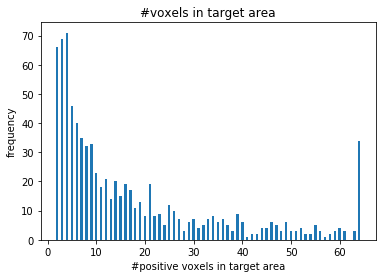

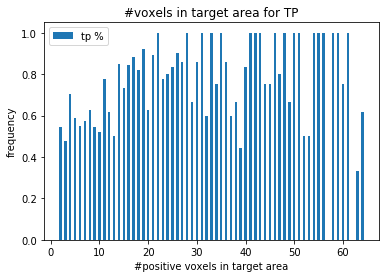

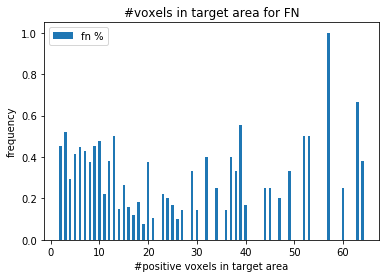

In [28]:
grid_spacing = 8
gt_labels = np.array(eval_batch.batch_gt_labels)
label_stats = np.array(eval_batch.target_labels_stats_per_roi[grid_spacing])

total_num_grids = gt_labels.shape[0]
total_positives = np.count_nonzero(label_stats != 0)
total_negatives = total_num_grids - total_positives

print("Total #grids={}; #negatives={}; #positives={}".format(total_num_grids, total_negatives, total_positives))

pred_labels = np.array(eval_batch.batch_pred_labels)
pred_probs = eval_batch.flatten_batch_probs()

tp_2, fn_2, tn_2, fp_2 = compute_tp_tn_fn_fp(pred_labels, gt_labels)
tp, fn, tn, fp = tp_2[0], fn_2[0], tn_2[0], fp_2[0]
print("Precision {:.3f} / Recall {:.3f}".format(float(tp)/(tp+fp), float(tp)/(tp + fn)))
tp_idx, fn_idx, tn_idx, fp_idx = tp_2[1], fn_2[1], tn_2[1], fp_2[1]

label_stats_tp = label_stats[tp_idx]
label_stats_fn = label_stats[fn_idx]
label_stats_fp = label_stats[fp_idx]
pred_probs_tp = pred_probs[tp_idx]
print("Number of fp={} fn={}".format(fp, fn))
num_all_voxels = np.sum(label_stats)
print("Voxels all={}, tp={:.2f}, fn={:.2f}".format(num_all_voxels, np.sum(label_stats_tp)/num_all_voxels, 
                                           np.sum(label_stats_fn)/num_all_voxels))

label_hist, bin_edges = np.histogram(label_stats, bins=np.unique(label_stats))
label_hist_fn, _ = np.histogram(label_stats_fn, bins=np.unique(label_stats))
label_hist_tp, _ = np.histogram(label_stats_tp, bins=np.unique(label_stats))

print(bin_edges.shape, label_hist.shape, label_hist_fn.shape, label_hist_tp.shape)
plt.bar(bin_edges[2:], label_hist[1:], 0.5, align='center')
plt.title("#voxels in target area")
plt.xlabel("#positive voxels in target area")
plt.ylabel("frequency")
plt.show()

tp_percs = label_hist_tp / label_hist.astype(np.float)
fn_percs = label_hist_fn / label_hist.astype(np.float)

# Note: bin_edges = [  0.   1.   2.   3 ...] Hence, we omit the first 2 entries because we're not interested
#                                            in the "negatives" i.e. the areas that don't contain positive voxels

plt.bar(bin_edges[2:], tp_percs[1:], width=0.5, align='center', label="tp %")
plt.legend(loc="best")
plt.title("#voxels in target area for TP")
plt.xlabel("#positive voxels in target area")
plt.ylabel("frequency")
plt.show()

plt.bar(bin_edges[2:], fn_percs[1:], width=0.5, align='center', label="fn %")
plt.legend(loc="best")
plt.title("#voxels in target area for FN")
plt.xlabel("#positive voxels in target area")
plt.ylabel("frequency")
plt.show()

# make plot with x-axis #voxels (as-is) and y-axis mean-softmax per bin



In [ ]:
rd1:
150000: loss 0.064: f1=0.488 - roc_auc=0.949 - pr_auc=0.517 - prec=0.606 - rec=0.408
200000: loss 0.068: f1=0.475 - roc_auc=0.947 - pr_auc=0.483 - prec=0.499 - rec=0.452
        
rd2:
150000: loss 0.102: f1=0.480 - roc_auc=0.948 - pr_auc=0.520 - prec=0.499 - rec=0.463
200000: loss 0.100: f1=0.511 - roc_auc=0.947 - pr_auc=0.527 - prec=0.533 - rec=0.490
        
rd2 with u-map distortion (random Gaussian noise)
loss 0.960: f1=0.016 - roc_auc=0.435 - pr_auc=0.018 - prec=0.011 - rec=0.027

rd2 with auto seg-mask distortion:
loss 0.886: f1=0.000 - roc_auc=0.502 - pr_auc=0.020 - prec=0.000 - rec=0.000

rd2 with image (mri) distortion:
loss 0.886: f1=0.000 - roc_auc=0.433 - pr_auc=0.017 - prec=0.000 - rec=0.000    

import SimpleITK as sitk
arr
img = sitk.GetImageFromArray(arr)
img.SetSpacing(origimg.GetSpacing())
sitk.WriteImage(fname, img)

In [66]:
from common.nms.nms_wrapper import nms